# Проектная работа

## Описание проекта

Имеются размеченныве данные с указанием возраста на ресурсе [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/). Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.

## План работы

1. [Исследовательский анализ набора фотографий.](#section1)
2. [Обучение модели](#section2)
3. [Анализ модели](#section3)

## Загрузим библиотеки

In [12]:
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

#для загрузки данных
from pathlib import Path
import os
import urllib.request

## Константы

In [1]:
SEED = 12345
TARGET_SIZE = (224, 224)
PATH = '/datasets/faces/'

## Функции

In [13]:
def set_seed(seed=SEED):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

In [14]:
def load_data(path, validation_split=None, seed=SEED, target_size=TARGET_SIZE):
    
    image_path = path + 'final_files'
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
                        validation_split=validation_split,
                        rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=image_path,
            x_col='file_name',
            y_col='real_age',
            target_size=target_size,
            batch_size=32,
            class_mode='raw',
            seed=seed) 
    return train_gen_flow

In [15]:
def plot_one_image(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    title_name = (str(title) + ' year' if title == 1 else str(title) + ' years')
    
    plt.title(title_name, fontsize=int(titlesize) if not red else int(titlesize/1.2),
              color='red' if red else 'black', fontdict={'verticalalignment':'center'},
              pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

In [16]:
def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return label, True
    correct = (label in list(range(correct_label - 3, correct_label + 3)))
    return "{} [{}{}{}]".format(label, 'OK' + "\u2192" + str(correct_label)  if correct else 'NO',
                                u"\u2192" if not correct else '',
                                correct_label if not correct else ''), correct

In [17]:
def plot_batch_of_images(databatch, predictions=None):
    
    if predictions is not None:
        print('Проверим визуально предсказание модели с разницей в +/- 3 года')
    
    # data
    images, labels = databatch


    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(np.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 15.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else labels[i]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 
        subplot = plot_one_image(image, title, subplot, not correct, titlesize=dynamic_titlesize)

    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [18]:
def create_model(input_shape):
    
    optimizer = Adam(lr=0.0001) 
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    
    
    model.add(Dense(1, activation='relu'))
 
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
 
    return model

In [19]:
def plot_training_curves(training, validation, title, subplot):
    if subplot%10==1: 
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## 1.2. Загрузим и изучим данные<a id='section1'></a>

In [20]:
datagen_flow = load_data(PATH)

Found 7591 validated image filenames.


In [21]:
labels_df = pd.read_csv(PATH + 'labels.csv')

In [22]:
labels_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [23]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [15]:
labels_df.duplicated().sum()

0

In [16]:
labels_df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


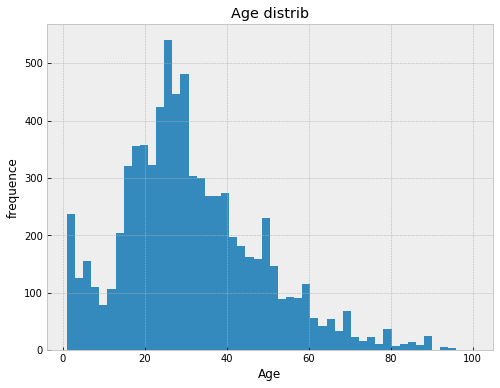

In [17]:
with plt.style.context('bmh'):
    plt.figure(figsize=(8,6))
    plt.hist(labels_df.real_age, bins=50)
    plt.title('Age distrib')
    plt.xlabel('Age')
    plt.ylabel('frequence')
    plt.show()

+ Дубликатов и пропусков не наблюдается
+ Распределение возраста - умерено скошено влево
+ Наблюдается меньшее количество фотографий в диапазоне возраста ~10 лет и болле 50 (причем на данном отрезке с убывающей тенденцией)
+ Возможно модель будет больше ошибаться в этих диапазонах

In [18]:
def info_about_datagen(datagen, labels):
    print(f'Количество батчей: {len(datagen)}')
    print(f'Количество изображений в батче: {len(iter(datagen)[0][0])}')
    _ = len(datagen) - 1
    print(f'Количество изображений в последнем батче: {len(iter(datagen)[_][0])}')
    _total_images = _ * len(iter(datagen)[0][0]) + len(iter(datagen)[_][0])
    print(f'Количество изображений: {_total_images}')
    if len(labels) == _total_images:
        print('Количество изображений соответствует количеству размеченых значений')
    else:
        print('Количество изображений НЕ соответствует количеству размеченых значений')

In [19]:
info_about_datagen(datagen_flow, labels_df)

Количество батчей: 238
Количество изображений в батче: 32
Количество изображений в последнем батче: 7
Количество изображений: 7591
Количество изображений соответствует количеству размеченых значений


Посмотрим на изображения в первом батче

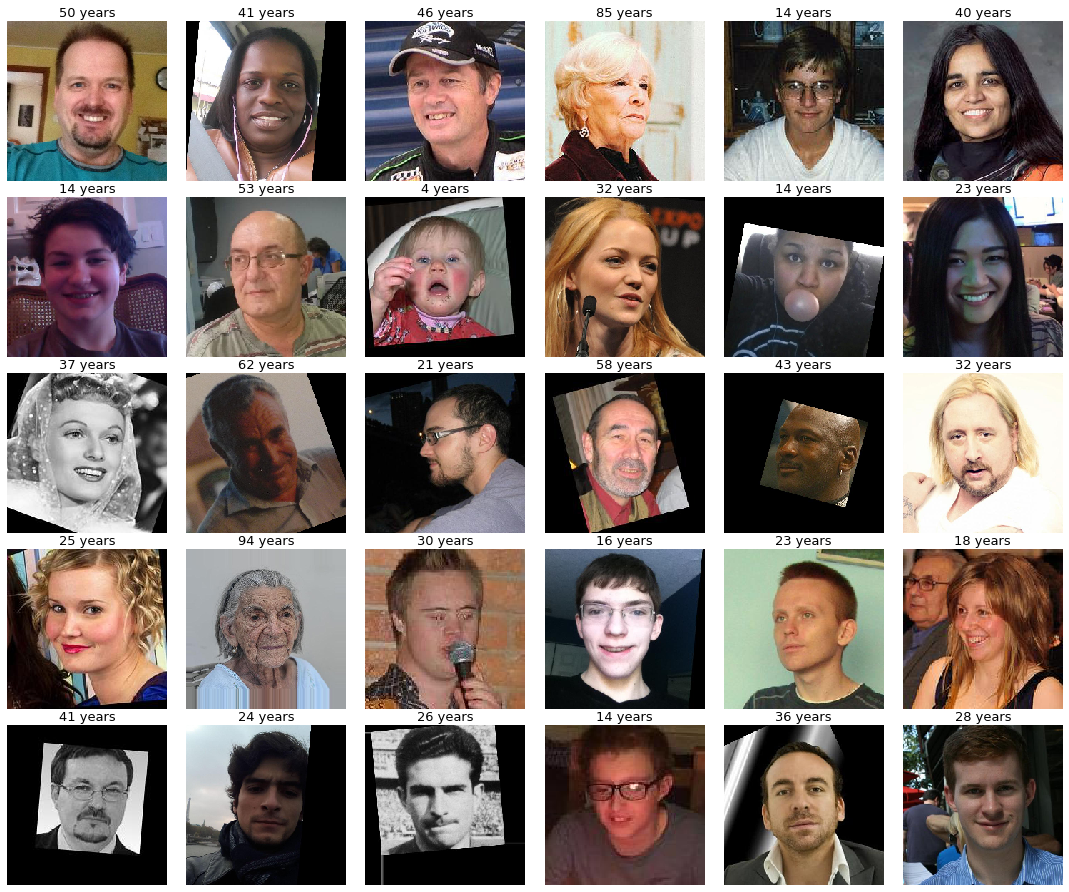

In [20]:
first_batch = iter(datagen_flow)[0]
plot_batch_of_images(first_batch)

# Вывод

+ Так как наблюдается смещение распределения по возрасту влево, то ожидается, что модель будет хуже определять возраст при значении возраста более чем 60 лет и в диапазоне около 10 лет;
+ Общей нехватки в данных для обучения не усматривается, тем не менее при недостаточном качестве можно будет применить аугментацию

# 2. Обучение модели<a id='section2'></a>

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np

 
def load_train(path):
    
    image_path = path + 'final_files'
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.25,
                                       horizontal_flip=True
                                      )
    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=image_path,
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345)
 
    return train_datagen_flow


def load_test(path):
    
    image_path = path + 'final_files'
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.25,
                                     )
    test_datagen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=image_path,
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345)
    
    return test_datagen_flow


def create_model(input_shape):
     
    optimizer = Adam(lr=0.0001) 
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())       
    model.add(Dense(1, activation='relu'))
 
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
 
    return model


def train_model(model, train_data, test_data, batch_size=32, epochs=12,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps, verbose=2,
              shuffle=True)
 
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/12
178/178 - 50s - loss: 225.9935 - mae: 10.7719 - val_loss: 846.8125 - val_mae: 24.2147
Epoch 2/12
178/178 - 41s - loss: 78.4793 - mae: 6.7022 - val_loss: 834.9447 - val_mae: 23.9195
Epoch 3/12
178/178 - 41s - loss: 48.3249 - mae: 5.2790 - val_loss: 469.1342 - val_mae: 16.4040
Epoch 4/12
178/178 - 40s - loss: 35.9366 - mae: 4.5624 - val_loss: 196.4706 - val_mae: 10.6092
Epoch 5/12
178/178 - 41s - loss: 27.5394 - mae: 4.0091 - val_loss: 85.7869 - val_mae: 7.0975
Epoch 6/12
178/178 - 41s - loss: 21.6364 - mae: 3.5631 - val_loss: 73.6148 - val_mae: 6.3966
Epoch 7/12
178/178 - 42s - loss: 17.0383 - mae: 3.1718 - val_loss: 65.4885 - val_mae: 6.2157
Epoch 8/12
178/178 - 42s - loss: 13.5354 - mae: 2.7961 - val_loss: 72.9453 - val_mae: 6.4345
Epoch 9/12
178/178 - 41s - loss: 12.4726 - mae: 2.6851 - val_loss: 71.4296 - val_mae: 6.3484
Epoch 10/12
178/178 - 41s - loss: 10.7819 - mae: 2.5086 - val_loss: 76.5809 - val_mae: 6.4578
Epoch 11/12
178/178 - 41s - loss: 9.3458 - mae: 2.3199 - val_loss: 63.0903 - val_mae: 5.9880
Epoch 12/12
178/178 - 41s - loss: 8.4086 - mae: 2.2151 - val_loss: 59.0105 - val_mae: 5.8012
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 59.0105 - mae: 5.8012
Test MAE: 5.8012

```

In [21]:
model = create_model([*TARGET_SIZE, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


# 3. Анализ обученной модели <a id='section3'></a>

In [22]:
def make_report_manually():
    
    _dict = {
        'epoch'      : list(range(1, 13)),
        'train_loss' : [225.9935, 78.4793, 48.3249, 35.9366, 27.5394, 21.6364,
                        17.0383, 13.5354, 12.4726, 10.7819, 9.3458, 8.4086],
        'train_mae'  : [10.7719, 6.7022, 5.2790, 4.5624, 4.0091, 3.5631,
                        3.1718, 2.7961, 2.6851, 2.5086, 2.3199, 2.2151],
        'val_loss'   : [846.8125, 834.9447, 469.1342, 196.4706, 85.7869, 73.6148,
                       65.4885, 72.9453, 71.4296, 76.5809, 63.0903, 59.0105],
        'val_mae'    : [24.2147, 23.9195, 16.4040, 10.6092, 7.0975, 6.3966,
                        6.2157, 6.4345, 6.3484, 6.4578, 5.9880, 5.8012]
    }
    return pd.DataFrame(_dict)

In [23]:
train_history = make_report_manually()

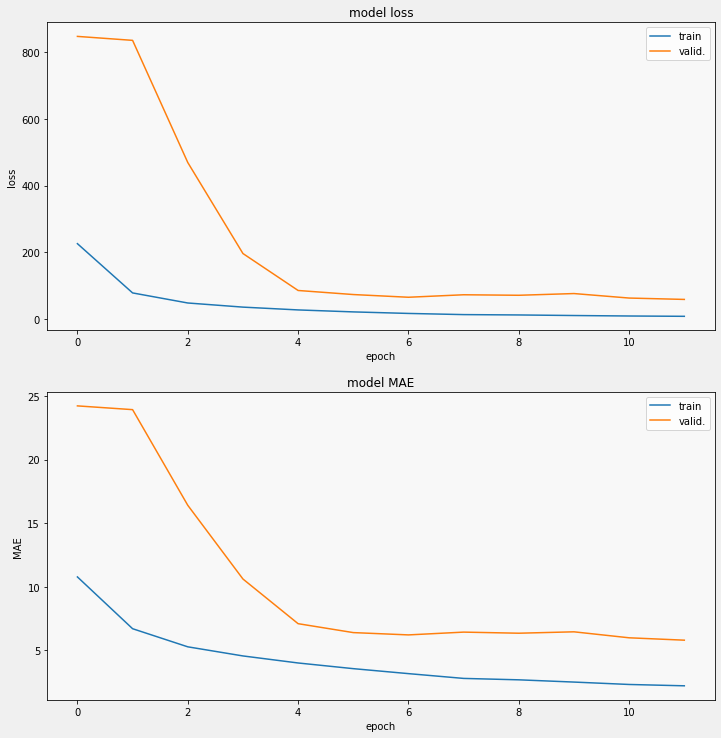

In [24]:
plot_training_curves(train_history.train_loss, train_history.val_loss, 'loss', 211)
plot_training_curves(train_history.train_mae, train_history.val_mae, 'MAE', 212)

Посмотрим после 4-ой эпохи

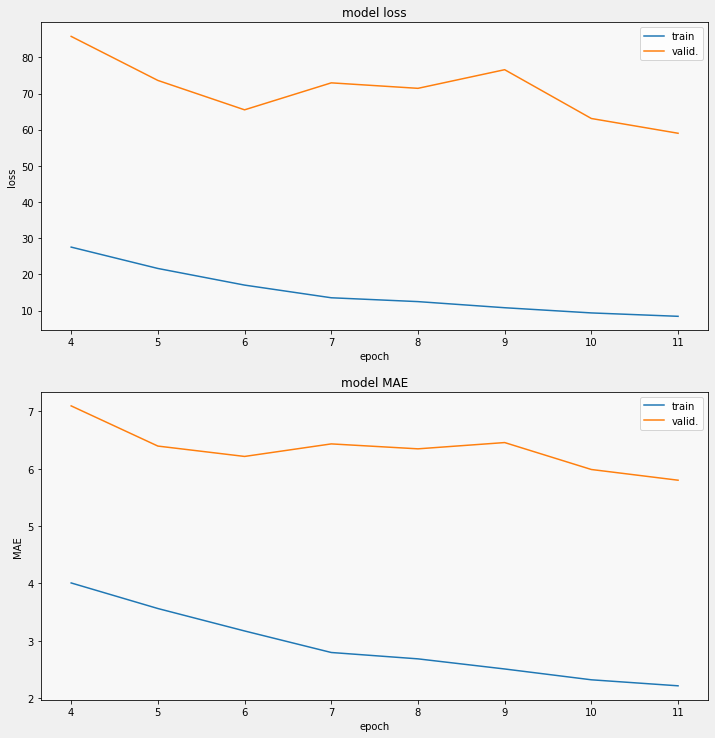

In [25]:
plot_training_curves(train_history.train_loss[4:], train_history.val_loss[4:], 'loss', 211)
plot_training_curves(train_history.train_mae[4:], train_history.val_mae[4:], 'MAE', 212)

На сколько видно на кривых обучения, модель достаточно обучилась для достижения поставленной задачи в достижении метрики МАЕ менее 8.
Однако наблюдается убывающий тренд как для функции потерь, так и для метрики МАЕ причем и для обучающей выборки и для тестовой. О чем можно сделать вывод, что потенциал получить более точную модель еще есть.

Загрузим эту же модель но обученную локально, на существующем датасете

In [26]:
Path('models').mkdir(parents=True, exist_ok=True)

In [27]:
def get_file(file_name, url):
    #Проверим есть ли файл
    if not os.path.exists(file_name):
        print(file_name, 'файл не найден, будет загружен из сети')
        #качаем файл по ссылке url, кладем по пути file_name
        _ = urllib.request.urlretrieve(url, file_name)

urls = {
    'url_with_weigths' : ('models/my_model_face_recogn.h5', 
                          'https://downloader.disk.yandex.ru/disk/4e25fec989693597868a9331b15bc88039d22b764f69fa958fd9c51f0593f78c/5fcf78be/ioqyilJTSGa38qYzB7lt8pP7S6ecIaYfmLWmhKTvw9KXFI4WidTP5pdXTJDOuqs_iWiQjwNJBD3ENY0j-G6O9Q%3D%3D?uid=0&filename=my_model_face_recogn.h5&disposition=attachment&hash=wOLbYpvRFp3YWISr13u%2BDX8TWiv0VZVTpqnsCSuHcDF3yVYhEewh6VEpaulEGB85q/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fx-hdf&owner_uid=681766158&fsize=283450544&hid=0fe17fc760e37c834d99272eb17ca303&media_type=data&tknv=v2'
                         )
                          }

[get_file(*urls[k]) for k in urls]

[None]

In [28]:
model =  models.load_model('models/my_model_face_recogn.h5')

In [29]:
first_test_batch = iter(datagen_flow)[0]
image, labels = first_test_batch

Проверим визуально предсказание модели с разницей в +/- 3 года


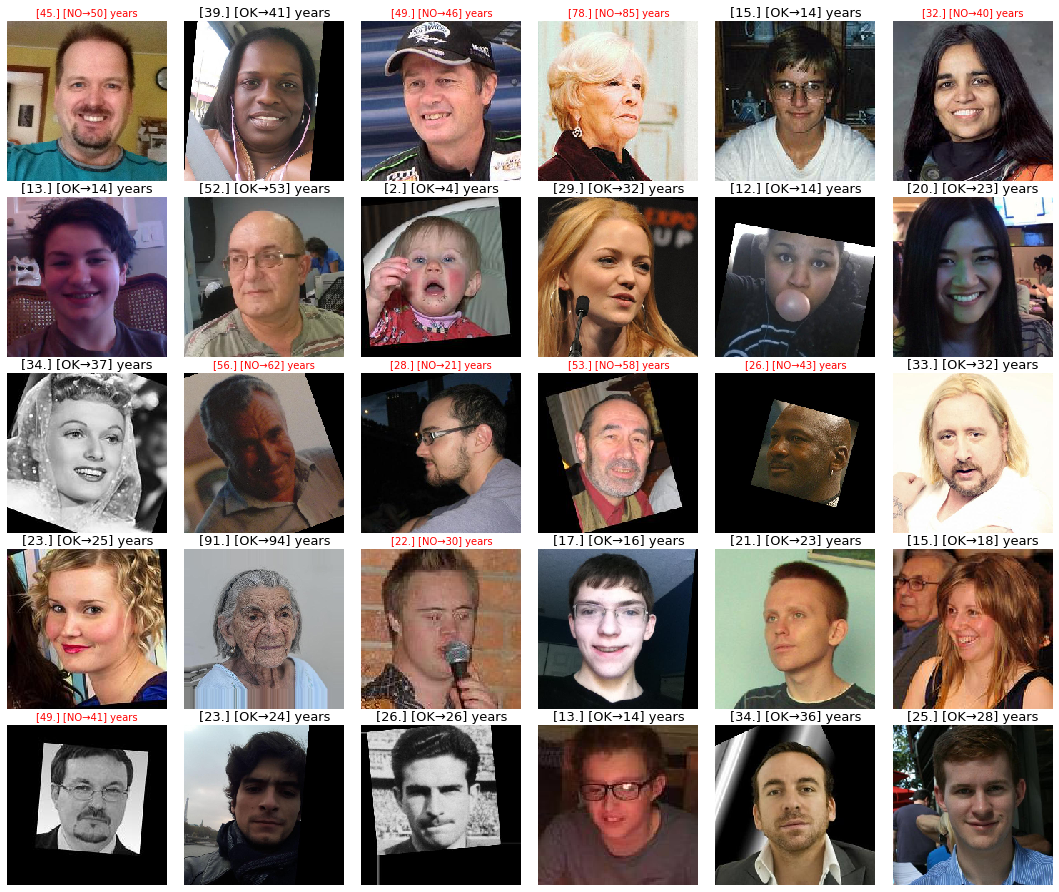

In [30]:
prediction = model.predict(image)
prediction_round = np.round(prediction)

plot_batch_of_images((image, labels), prediction_round)

# Вывод

1. Модель достигла требуемого значения качества - МАЕ=5,8
2. Судя по кривым обучения модель еще имеет потенциал к улучшению
3. По предсказаниям выборки из первого батча можно сделать вывод, что модель действительно достаточно точно предсказывает возраст с точностью +/- 3 года.
4. Если произвести быстрый визуальный анализ фотографий из первого батча, то можно заметить, что фотографии имеют некоторые отличительные особенности не свойственные другим фото:
    * головной убор,
    * выраженные борода/усы на лице,
    * женщина-космонавт,
    * черезмерно затемненная часть лица;
    * закрыта часть лица микрофоном и возможно отклонение в физической форме
    * темнокожий Майкл Джордан
5. Как из решений по улучшению модели можно предложить обогатить выборку нетипичными фото лиц